In [ ]:
# pip install --quiet scvi-tools

In [1]:
# !pip install scDREAMER
import scDREAMER

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scib
import louvain

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [4]:
import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [5]:
# setting seed for reproducibility
np.random.seed(666)
tf.set_random_seed(666)
random.seed(666)
tf2.random.set_seed(666)
tf2.keras.utils.set_random_seed(666)

In [6]:
import anndata
adata = anndata.read_h5ad("../human_pancreas_norm.h5ad")
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [7]:
adata.obs['cell_type'] = adata.obs['celltype']
adata.obs['batch'] = adata.obs['tech']
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'cell_type', 'batch'
    layers: 'counts'

In [14]:
import pandas as pd
import numpy as np

# Function to set up the described setting with randomly selected batches for annotation
def cell_type_annotation_by_batch_random(adata, seed=666, annotation_fraction=0.7):
    # Set seed for reproducibility
    np.random.seed(seed)

    # Get the unique batches
    unique_batches = adata.obs['batch'].unique()

    # Randomly select a fraction of the batches to have annotations
    num_batches_to_annotate = int(len(unique_batches) * annotation_fraction)
    batches_with_annotations = np.random.choice(unique_batches, num_batches_to_annotate, replace=False)

    # Initialize all labels with NaN
    adata.obs['celltype'] = np.nan

    # Assign labels only to the selected batches
    for batch in batches_with_annotations:
        annotated_indices = adata.obs[adata.obs['batch'] == batch].index
        adata.obs.loc[annotated_indices, 'celltype'] = adata.obs.loc[annotated_indices, 'cell_type']

    # Fill remaining NaN values with "Unknown"
    adata.obs['celltype'].fillna("Unknown", inplace=True)
    adata.obs['celltype'] = adata.obs['celltype'].astype('category')

    return adata

In [15]:
# Example usage
adata = cell_type_annotation_by_batch_random(adata, seed=666, annotation_fraction=0.7)

# Display the first few rows of 'batch', 'cell_type', and 'batch_labels' to verify
adata.obs[['batch', 'cell_type', 'celltype']].head()

,batch,cell_type,celltype
D101_5,celseq,gamma,gamma
D101_43,celseq,gamma,gamma
D101_93,celseq,gamma,gamma
D102_4,celseq,gamma,gamma
D172444_23,celseq,gamma,gamma


In [17]:
# Write `adata.obs` to a CSV file named 'metadata.csv'
adata.obs.to_csv('./labels_for_new_methods/partially_annotated_label_human_pancreas_70_obs.csv')

In [18]:
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'cell_type', 'batch'
    layers: 'counts'

In [19]:
adata.write('./labels_for_new_methods/human_pancreas_partially_annotated_70.h5ad')

In [10]:
embeddings_dict = {}

## scDREAMER
scDREAMER takes h5ad file directly as input.


Leaning rate to use for small data vs large input data: 
learning_rate = {
    "Immune_Human": {"lr_ae": 0.0002, "lr_dis": 0.0007},  # Small Datasets
    "Human_Mouse": {"lr_ae": 0.0001, "lr_dis": 0.00001},
}  # Big Datasets >= 0.5 million cells

it does the data preprocessing by its own function: 
	•	read_h5ad: This function reads the data from an .h5ad file using Scanpy and performs several preprocessing steps:
	•	Normalization: Total counts per cell are normalized to 10,000.
	•	Log Transformation: A log transformation is applied to the data.
	•	Highly Variable Genes: The top 2,000 highly variable genes are selected based on the Seurat method, using the batch key for batch correction.
	•	Data Preparation: The data is then converted into a dense or sparse matrix, depending on sparseIP.
	•	One-Hot Encoding: Batch information and cell type labels are one-hot encoded, which will be used later in the model.
	•	load_gene_mtx: This function loads the dataset, processes it using read_h5ad, and prepares it for input into the model. It handles transformations, normalization, and returns the processed data along with labels and batch information.

Loading dataset
Preprocessing...
here [9 9 9 ... 9 9 9]
Shape self.data_train: (16382, 2000)
Shape self.data_test: (16382, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2009), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 19), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet ./labels_for_new_methods/human_pancreas_partially_annotated_70.h5ad ... 
Epoch : [0] ,  a_loss = 706.7206
Epoch : [10] ,  a_loss = 550.2656
Epoch : [20] ,  a_loss = 528.7458
Epoch : [30] ,  a_loss = 516.3980
Epoch : [40] ,  a_

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


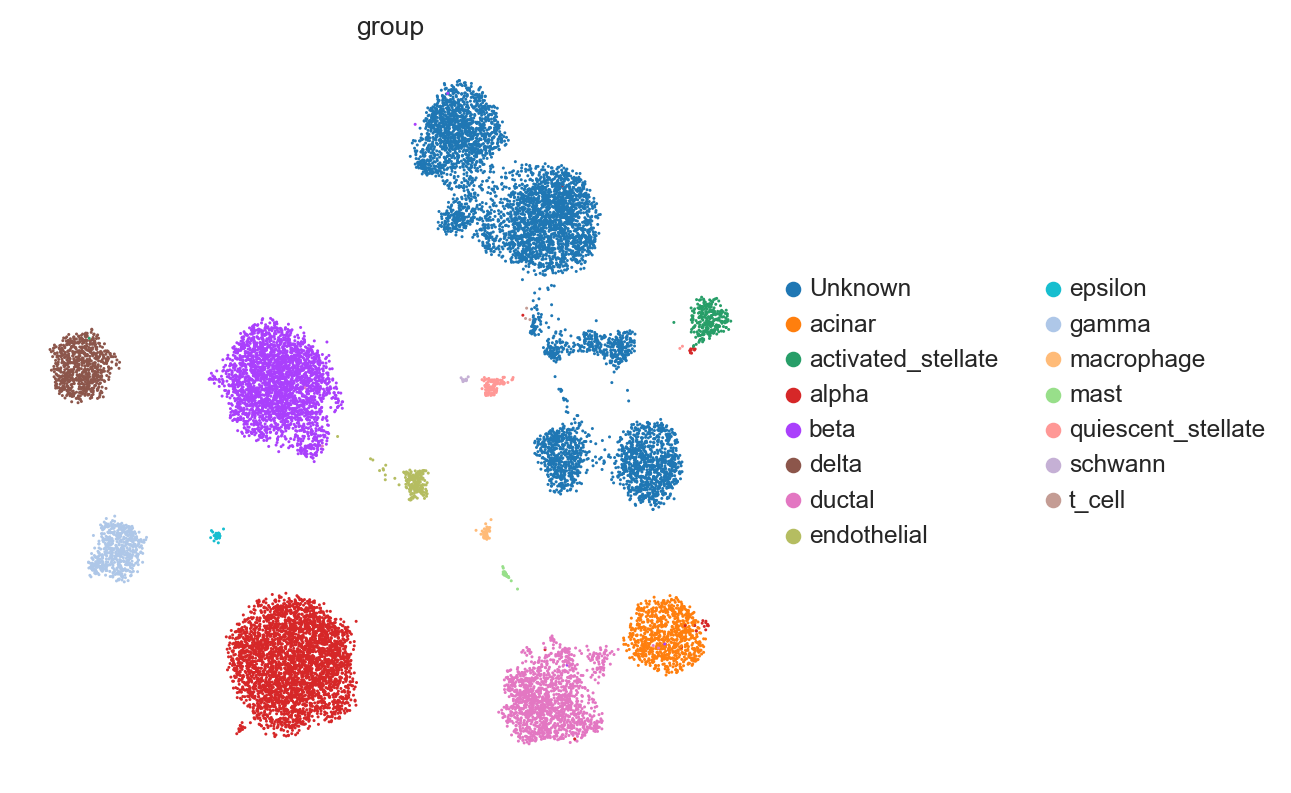

None


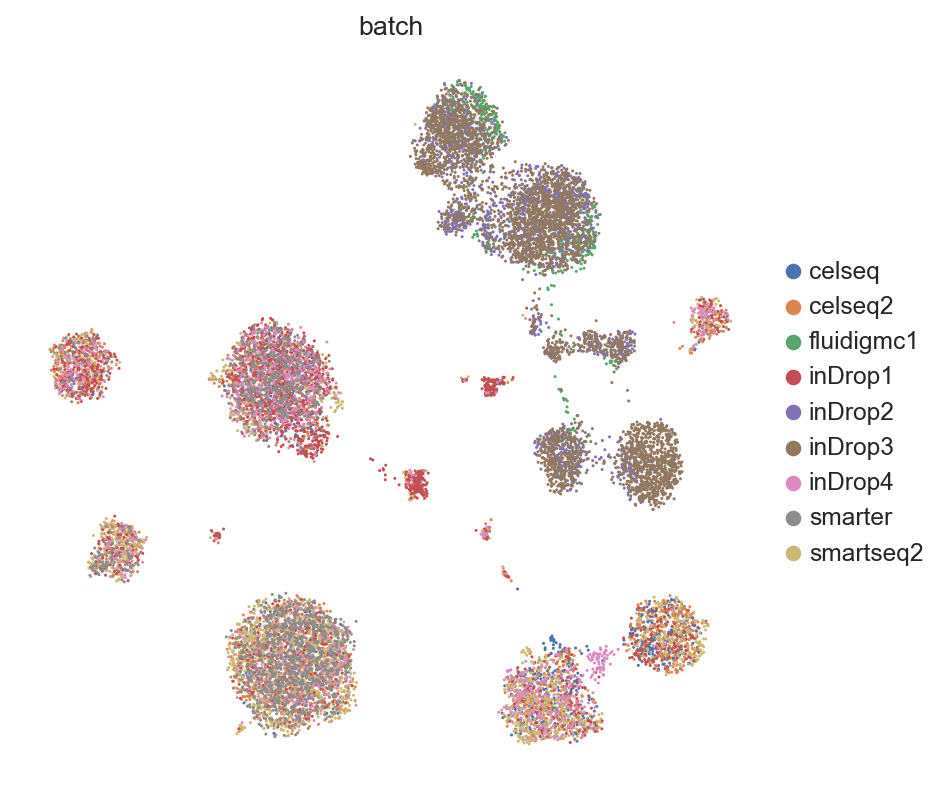

None


In [21]:
import tensorflow as tf
from scDREAMER import scDREAMER_SUP

# Define the single dataset and relevant parameters
name = "human_pancreas_70"
dataset_path = "./labels_for_new_methods/human_pancreas_partially_annotated_70.h5ad"

# Define batch and cell type keys
batch_key = 'batch'
cell_type_key = 'celltype'

# Learning rate configuration
lr = {"lr_ae": 0.0002, "lr_dis": 0.0007}

# TensorFlow session configuration
tf.compat.v1.disable_eager_execution()  # Disable eager execution to mimic TensorFlow 1.x behavior
run_config = tf.compat.v1.ConfigProto()
run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

# Run scDREAMER
with tf.compat.v1.Session(config=run_config) as sess:
    dreamer = scDREAMER_SUP(
        sess,
        epoch=240,
        dataset_name=dataset_path,
        batch=batch_key,
        cell_type=cell_type_key,
        plot_cell_type=cell_type_key,
        name=name,
        lr_ae=lr['lr_ae'],
        lr_dis=lr['lr_dis']
    )

    dreamer.train_cluster()

In [8]:
import pandas as pd
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/partially_annotated_batches_scdreamer_embeddings_human_pancreas_70.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = adata.obsm['X_scDREAMER']

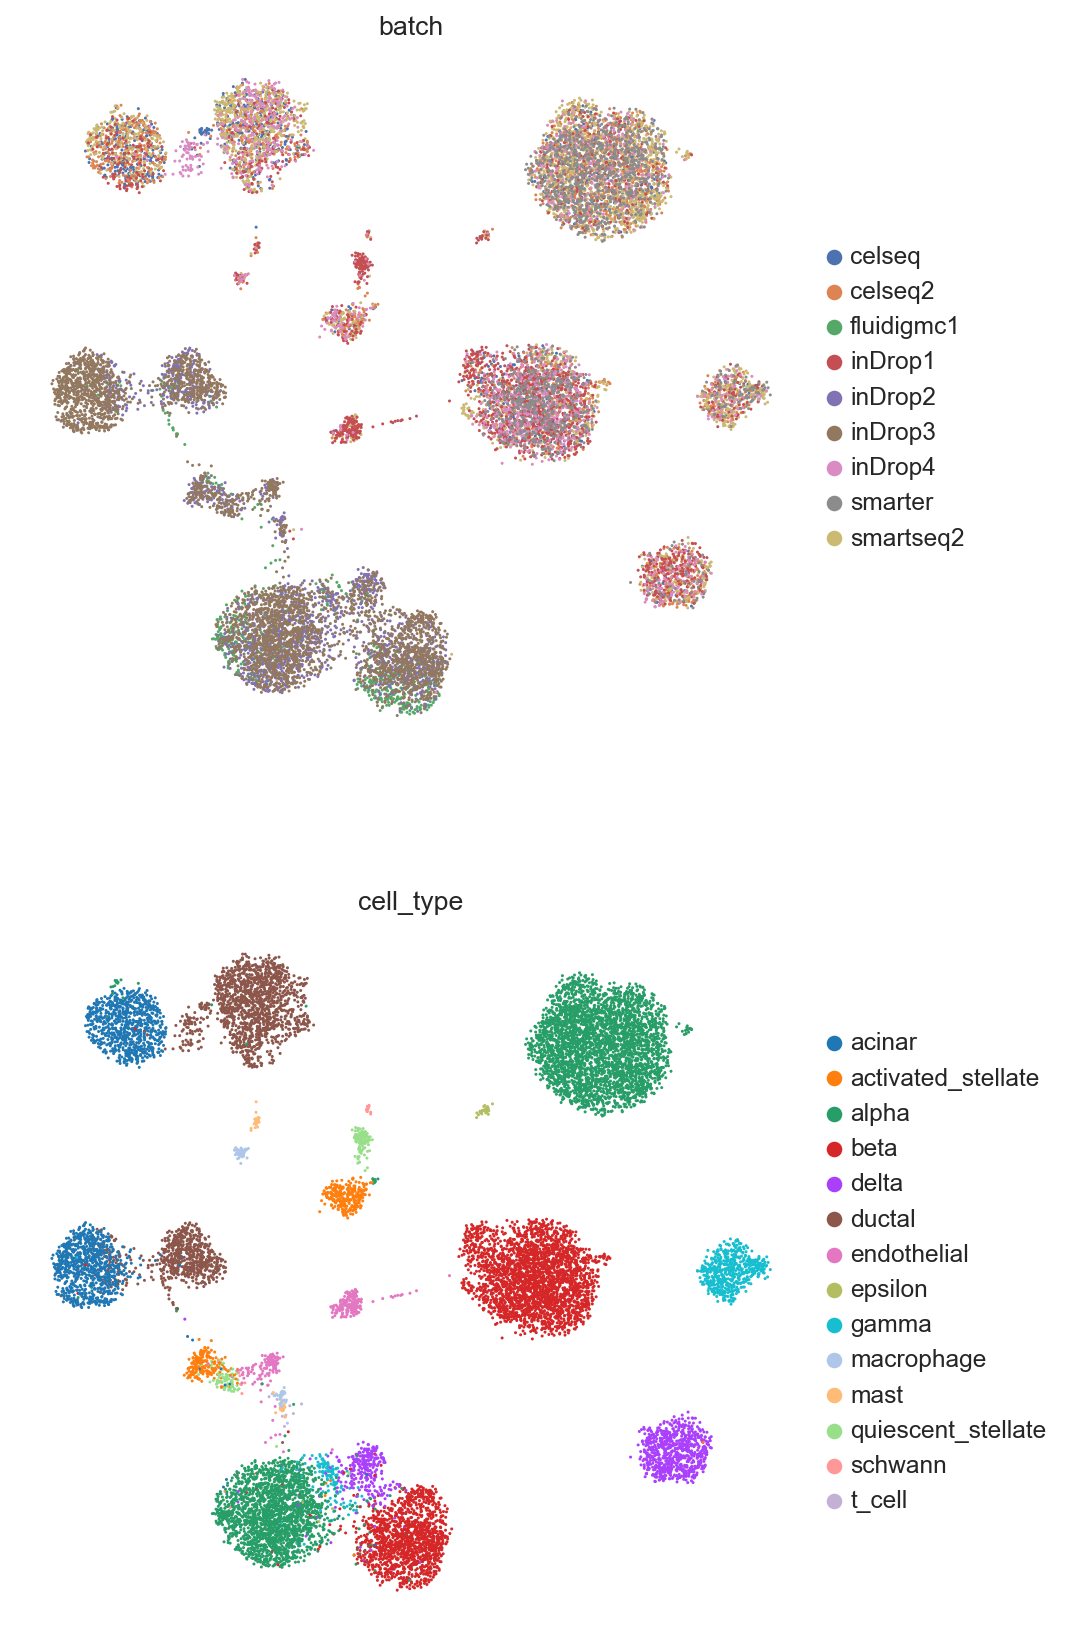

In [12]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# ItClust

In [13]:
pca_embeddings = pd.read_csv('../embeddings/new_methods_embeddings/partially_annotated_batches_human_pancreas_itclust_embeddings_70.csv', index_col=0)
adata.obsm['X_ItClust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_ItClust")
sc.tl.umap(adata, min_dist=0.5)

In [14]:
# Collect embeddings
embeddings_dict["X_ItClust"] = adata.obsm['X_ItClust']

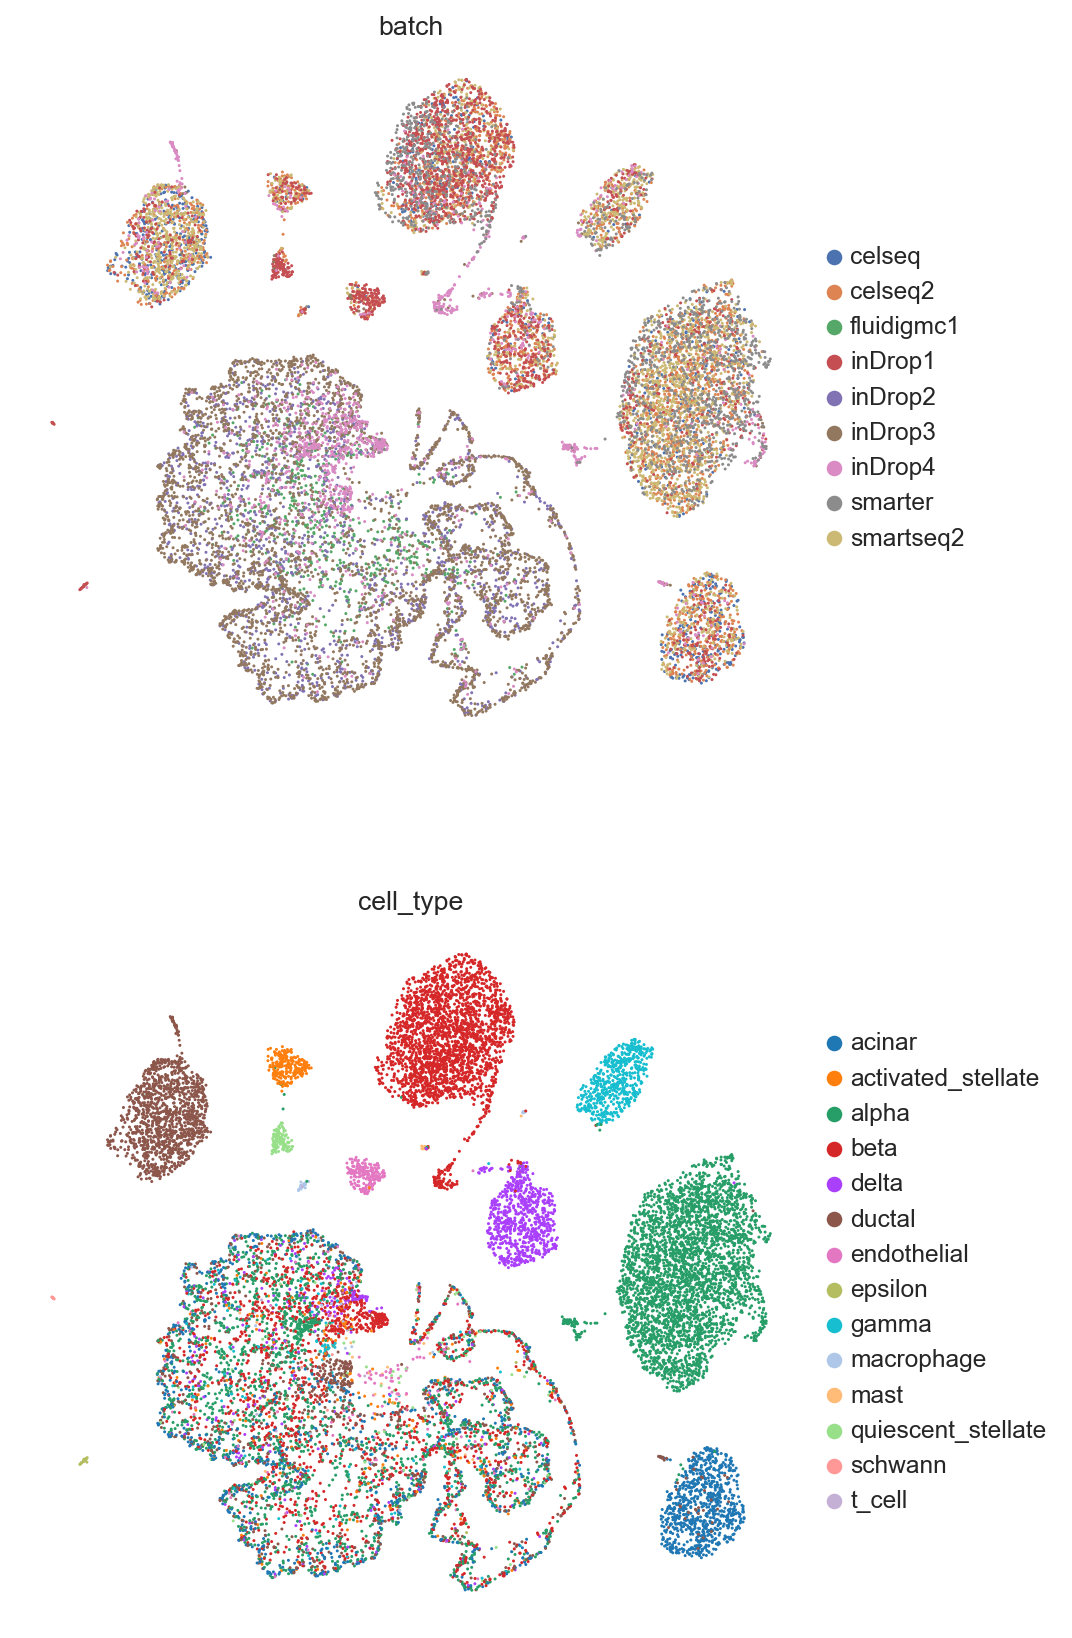

In [15]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [16]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/partially_annotated_batches_human_pancreas_new_70.csv")
